# Properties of the infectivity matrix

[Index](0-index.ipynb)

We show the random matrix properties of the SafeGraph derived infectivity matrices.

## Imports and global variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import datetime
from scipy.special import xlogy

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append('../code')
from functions import show_image

In [4]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'safegraph_analysis.hdf5'
complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 2188 entries.


In [6]:
gamma = 1/10.
ti = '2020-03-01'
tf = '2021-02-16'

tfmt = '%Y-%m-%d'
ti = datetime.datetime.strptime(ti, tfmt)
tf = datetime.datetime.strptime(tf, tfmt)
exts = ['.png', '.svg']
dpi=300

In [7]:
nt = (tf-ti).days + 1
times = [ti + datetime.timedelta(days=n) for n in range(nt)]

## Clusters

### Load clusters

In [8]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
# clusters = pd.read_hdf(resfile, key)
N = len(clusters)
print(f"N = {N}")
clusters

N = 1024


,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


In [9]:
key = "/clustering/cbgs_clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    cbgs_labels = store[key]

df = clusters.copy().loc[:,'leaves'].reset_index().set_index('leaves')
cbgs_labels['index'] = -1

for cbgs in cbgs_labels.index:
    cbgs_labels.at[cbgs, 'index'] = df.at[cbgs_labels.at[cbgs, 'leaves'],'index']

cbgs_labels

,leaves,index
CensusBlockGroup,,
10810416001,68,200
10810416002,68,200
10810417004,68,200
10730111074,440,195
10730111084,440,195
...,...,...
720851902012,746,0
720851902013,746,0
720851902021,746,0


In [10]:
figdir = Path('..') / 'figures' / '12-infectivity_matrix_properties'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

## Compute infectivity matrices

In [11]:
from functions import get_infectivity_matrix

In [12]:
# parameters
npool = 2**3
pathana = Path('/infectivity_matrix_properties')

In [13]:
pathtoflux = Path('/fluxes')
N = len(clusters)
matrices = []
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    for t in times:
        mykey = pathtoflux / t.strftime(tfmt)
        mykey = str(mykey)
        df_flux = store[mykey]
        mat = get_infectivity_matrix(df_flux.to_numpy().astype('float64'))
        mat = 0.5*(mat+mat.T)  # symmetrize it for eigenvalue analysis
        matrices.append(mat)
matrices = np.array(matrices)

L_mean = np.mean(matrices, axis=0)
L_std = np.std(matrices, axis=0)

## Show mean matrix

In [14]:
fname = 'localization_mean_npool{:d}'.format(npool)
for ext in exts:
    fpath = figdir / (fname + ext)
    fpath = str(fpath)
    fig = show_image(L_mean, downscale=npool, log=True, mpl=True, vmin=1.0e-5, vmax=1.0, method='max', fileout=fpath)

Written file ../figures/12-infectivity_matrix_properties/localization_mean_npool8.png
Written file ../figures/12-infectivity_matrix_properties/localization_mean_npool8.svg


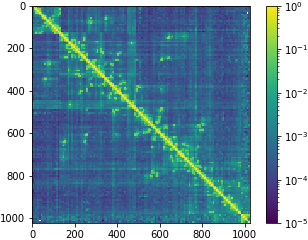

In [15]:
fname = 'localization_mean_npool{:d}'.format(npool)
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [16]:
fname = 'localization_std_npool{:d}'.format(npool)
for ext in exts:
    fpath = figdir / (fname + ext)
    fpath = str(fpath)
    fig = show_image(L_std, downscale=npool, log=True, mpl=True, vmin=None, vmax=None, method='max', fileout=fpath)

Written file ../figures/12-infectivity_matrix_properties/localization_std_npool8.png
Written file ../figures/12-infectivity_matrix_properties/localization_std_npool8.svg


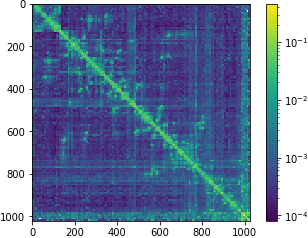

In [17]:
fname = 'localization_std_npool{:d}'.format(npool)
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Show the noise distribution

In [18]:
import scipy.stats as scs

In [19]:
# only consider elements with non-zero mean (zero-inflation issue)
idx = L_mean > 0.
data = []
data_mean = []
data_std = []
for i in range(len(matrices)):
    idxi = matrices[i] > 0.
    idxi = idx & idxi
    data.append(matrices[i][idxi])
    data_mean.append(L_mean[idxi])
    data_std.append(L_std[idxi])

data = np.concatenate(data)
data_mean = np.concatenate(data_mean)
data_std = np.concatenate(data_std)

idx = np.argsort(data)
data = data[idx]
data_mean = data_mean[idx]
data_std = data_std[idx]

#### Multiplicative noise

In [20]:
V = data / data_mean

# nbins=2**6
nbins='doane'
q = 0.00
n = len(V)
n1 = int(0.5*q*n)
n2 = int((1. - 0.5*q)*n)
print(f"n1 = {n1}, n2 = {n2}")

fig = plt.figure(figsize=(4,3), dpi=150)
lw=0.5
ax = fig.gca()

hist, edges = np.histogram(np.log(V[n1:n2]), bins=nbins, density=True)

print(f"nbins = ", len(edges)-1)
# ax.plot(0.5*(edges[:-1]+edges[1:]), hist, '-o', lw=0.5, color='darkblue', ms=2)
ax.bar(edges[:-1], hist, np.diff(edges), lw=lw, color='lightblue', ec='k')

m = np.mean(np.log(V[n1:n2]))
s = np.std(np.log(V[n1:n2]))
m,s = scs.norm.fit(np.log(V[n1:n2]), loc=m, scale=s)
npts = 1000
X = np.linspace(edges[0], edges[-1], npts)
Y = 1./ np.sqrt(2.*np.pi*s**2)*np.exp(-0.5*(X-m)**2/s**2)
ax.plot(X,Y,'r--',lw=0.5, label="$\\mu = {:.2f}$\n$\sigma = {:.2f}$".format(m, s))

ax.legend(loc='best', fontsize='medium', frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("$\ln{(x_{ij}/<x_{ij}>)}$", fontsize='large')
ax.set_ylabel("pdf", fontsize='medium')
ax.set_ylim(0,None)
fig.tight_layout()
# plt.show()

fname = 'noise_dist_multiplicative'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

n1 = 0, n2 = 142838237
nbins =  40
Written file: ../figures/12-infectivity_matrix_properties/noise_dist_multiplicative.png
Written file: ../figures/12-infectivity_matrix_properties/noise_dist_multiplicative.svg


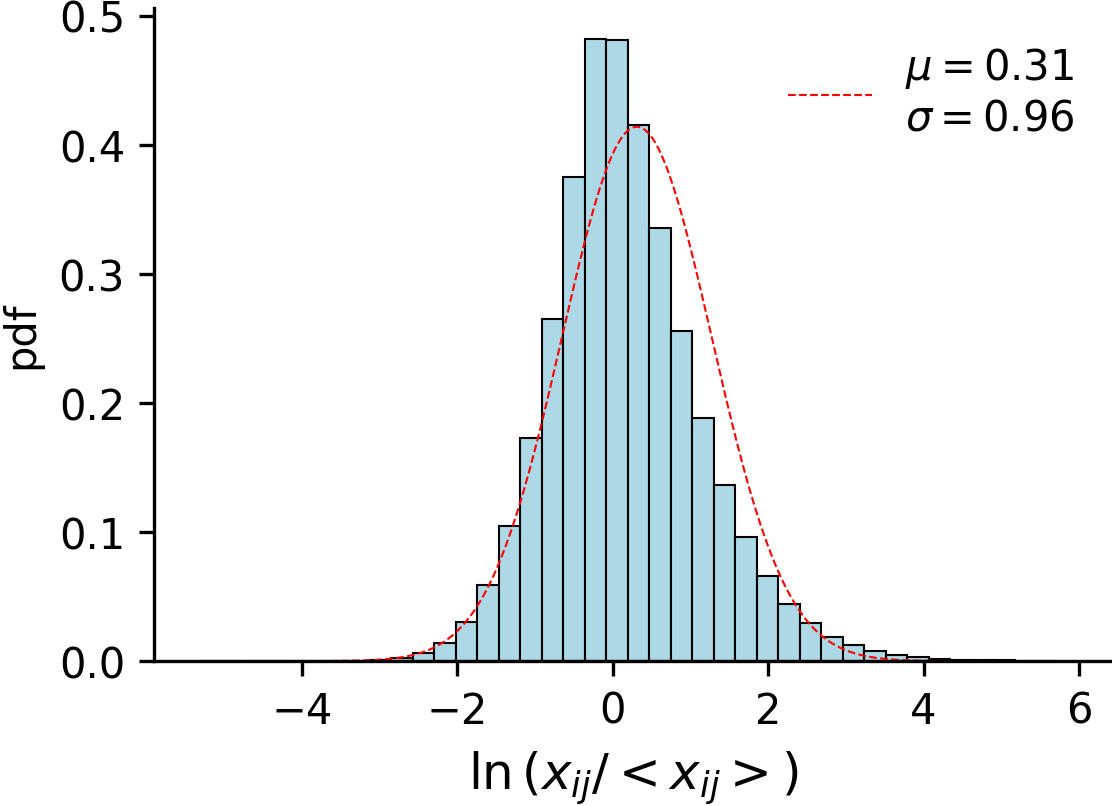

In [21]:
fname = 'noise_dist_multiplicative'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

#### Additive noise

In [22]:
V = (data - data_mean)/data_std

# nbins=2**6
nbins='doane'
q = 0.05
n = len(V)
n1 = int(0.5*q*n)
n2 = int((1. - 0.5*q)*n)
print(f"n1 = {n1}, n2 = {n2}")

fig = plt.figure(figsize=(4,3), dpi=150)
lw=0.5
ax = fig.gca()

hist, edges = np.histogram(V[n1:n2], bins=nbins, density=True)
# hist, edges = np.histogram(np.log(data[n1:n2]), bins=nbins, density=True)

print(f"nbins = ", len(edges)-1)
# ax.plot(0.5*(edges[:-1]+edges[1:]), hist, '-o', lw=0.5, color='darkblue', ms=2)
ax.bar(edges[:-1], hist, np.diff(edges), lw=lw, color='lightblue', ec='k')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("$(x_{ij} - <x_{ij}>)/\sigma_{ij}$", fontsize='large')
ax.set_ylabel("pdf", fontsize='medium')
ax.set_ylim(0,None)
fig.tight_layout()
# plt.show()

fname = 'noise_dist_additive'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

n1 = 3570955, n2 = 139267281
nbins =  42
Written file: ../figures/12-infectivity_matrix_properties/noise_dist_additive.png
Written file: ../figures/12-infectivity_matrix_properties/noise_dist_additive.svg


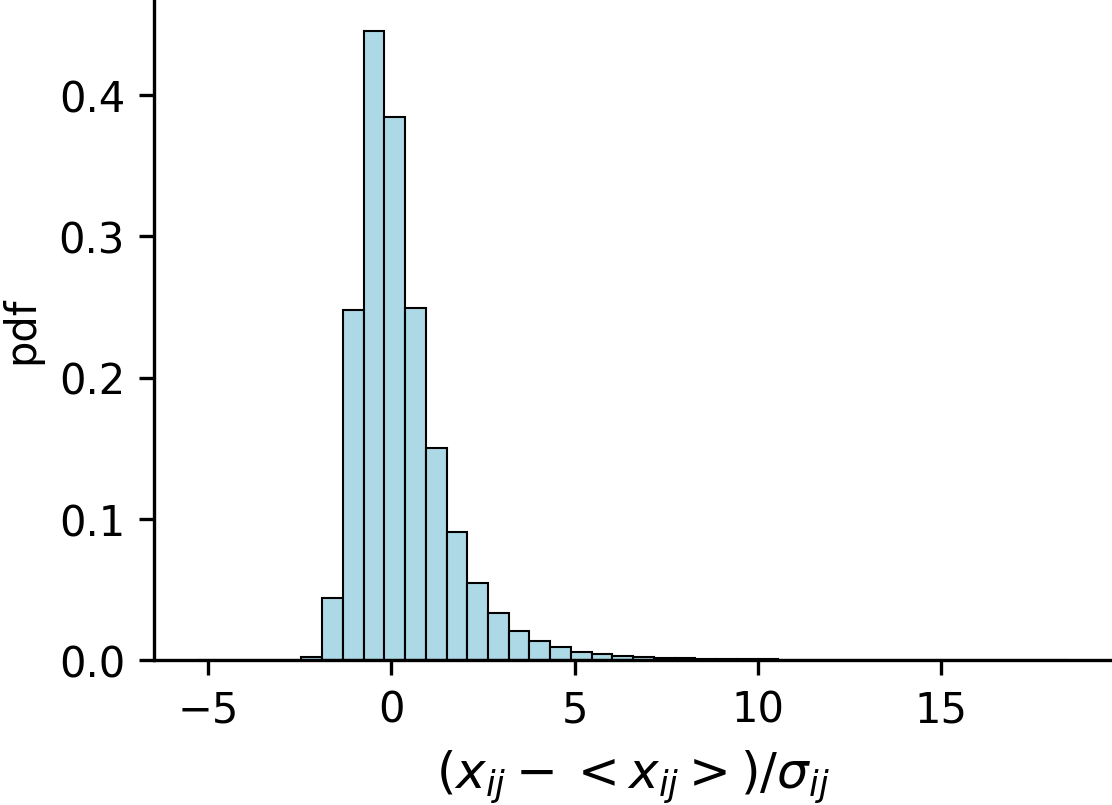

In [23]:
fname = 'noise_dist_additive'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Eigenvalue distribution of the mean matrix

In [24]:
from functions import get_binned, unfold_positive
from dateutil.relativedelta import relativedelta

In [25]:
w = np.linalg.eigvals(L_mean)
w = np.sort(w)

In [26]:
# parameters
# nbins='doane'
nbins = 2**5
figsize=(4,3)
lw=0.5
elw=0.5
ms=2
q = 0.00
pts_per_bin = 6
n = len(w)
n1 = int(0.5*q*n)
n2 = int((1. - 0.5*q)*n)
print(f"n1 = {n1}, n2 = {n2}")

hist, edges = np.histogram(w[n1:n2], bins=nbins, density=True)
print(f"nbins = ", len(edges)-1)
X = 0.5*(edges[:-1]+edges[1:])

w_binned = get_binned(w[n1:n2], w[n1:n2], edges)

w_n = np.array([len(x) for x in w_binned])
w_mean = np.array([np.mean(x) for x in w_binned])
w_std = np.array([np.std(x) for x in w_binned])

w_err = np.ones(w_n.shape, dtype=np.float_)*np.nan

idx = ~(w_n < pts_per_bin)
# w_err[idx] = 1
# w_err[idx] = w_std[idx] / np.sqrt(w_n[idx])

fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()

# ax.plot(X, hist, '-o', lw=lw, color='darkblue', ms=ms)
ax.bar(edges[:-1], hist, np.diff(edges), lw=lw, color='lightblue', ec='k')
# ax.errorbar(X[idx], hist[idx], yerr=w_err[idx], ls='-', marker='o', lw=lw, elinewidth=elw, ms=ms, color='darkblue')

# ax.legend(loc='best', fontsize='medium', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
ax.set_xlabel("x", fontsize='large')
ax.set_ylabel("pdf", fontsize='medium')
ax.set_ylim(0,None)
fig.tight_layout()
# plt.show()

fname = 'eigenvalue_dist_mean'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

n1 = 0, n2 = 1024
nbins =  32
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_dist_mean.png
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_dist_mean.svg


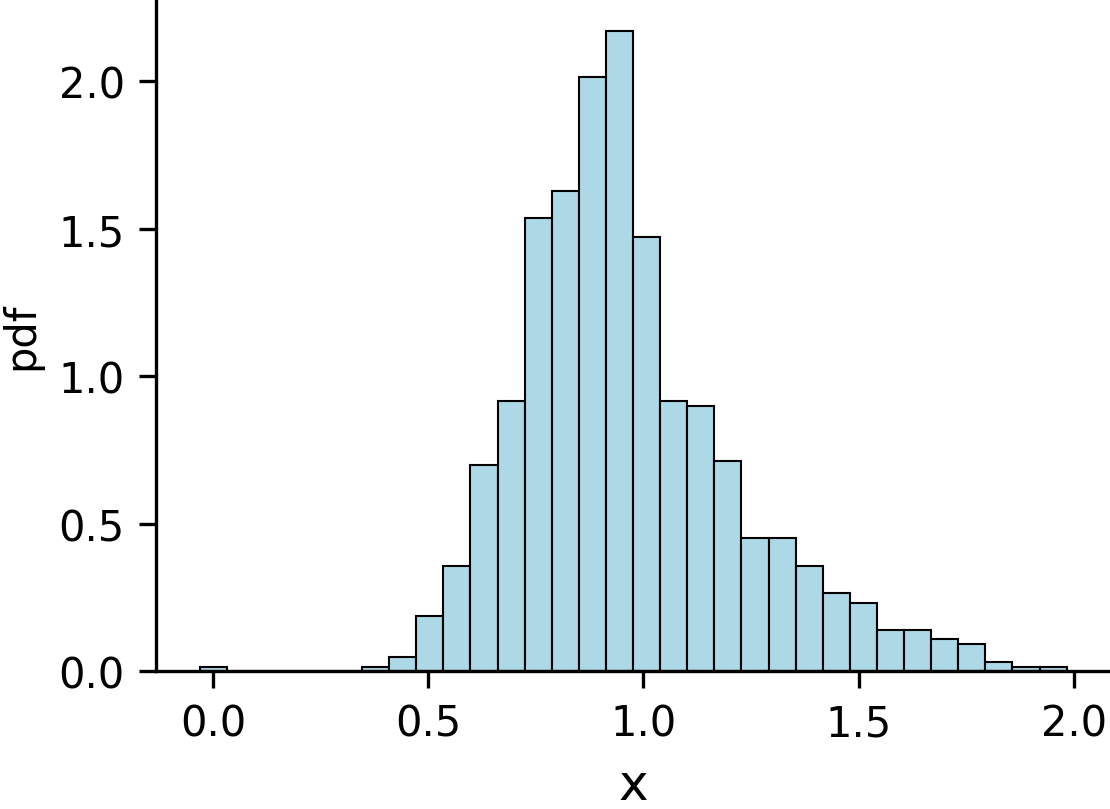

In [27]:
fname = 'eigenvalue_dist_mean'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [28]:
# parameters
# nbins='doane'
ninterp = 2**6
nbins = 2**5

figsize=(4,3)
lw=0.5
elw=0.5
ms=2

w0 = np.min(w)
E = w.reshape(1,-1) - w0

# gaps
# hist, edges = np.histogram(np.diff(E), bins=nbins, density=True)
# plt.plot(X, hist)

# unfolded gaps
hist, edges = unfold_positive(E, n=ninterp, deg=12, nbins=nbins)
nbins = len(edges) - 1
print("nbins = {:d}".format(nbins))
X = 0.5*(edges[:-1]+edges[1:])
print(edges[0])

# remove values smaller than 0
# problem in polynomial fitting
idx = ~(X < 0.)
hist = hist[idx]
X = X[idx]
dx = np.diff(X)[0]
Z = np.sum(hist)*dx
hist /= Z
print(np.sum(hist)*dx)

# make figure
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()

# ax.plot(X, hist, '-o', lw=lw, color='darkblue', ms=ms)
ax.bar(edges[:-1][idx], hist, np.diff(edges)[0], lw=lw, color='lightblue', ec='k')
# ax.errorbar(X[idx], hist[idx], yerr=w_err[idx], ls='-', marker='o', lw=lw, elinewidth=elw, ms=ms, color='darkblue')

# ax.legend(loc='best', fontsize='medium', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
ax.set_xlabel("x", fontsize='large')
ax.set_ylabel("pdf", fontsize='medium')
ax.set_ylim(0,None)
fig.tight_layout()
# plt.show()

fname = 'eigenvalue_gaps_unfolded_mean'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

nbins = 32
-0.0008845207622831808
0.9999999999999999
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_gaps_unfolded_mean.png
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_gaps_unfolded_mean.svg


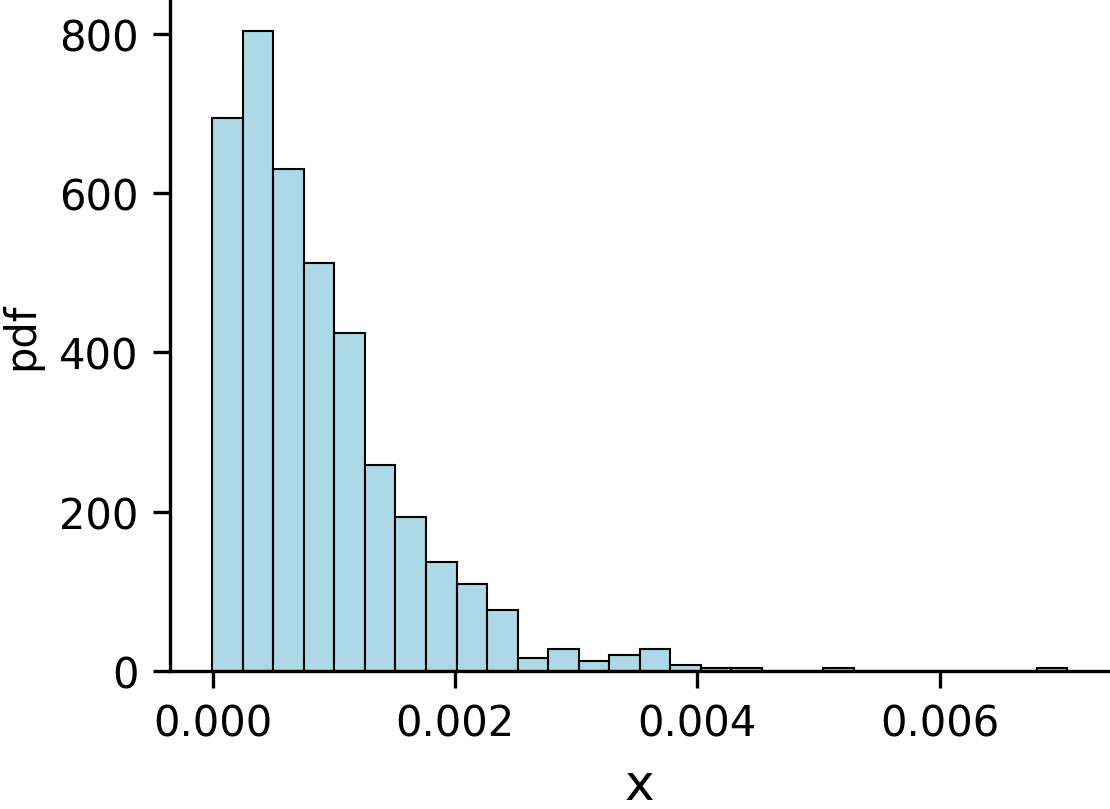

In [29]:
fname = 'eigenvalue_gaps_unfolded_mean'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Eigenvalue analysis

In [30]:
# takes a long time
Es = np.array([np.sort(np.linalg.eigvalsh(L)) for L in matrices])

Export eigenvalues to csv

In [31]:
expdir = resdir / 'csv'
if not expdir.is_dir():
    expdir.mkdir()

In [32]:
fname = 'eigenvalues.csv'
pd.DataFrame(data=Es, index=times, columns=clusters.index).to_csv(expdir / fname)

In [33]:
fname = 'eigenvalues.csv'
sel = 'Unnamed: 0'
Es = pd.read_csv(expdir / fname).rename(columns={sel : 'times'}).set_index(keys='times')
Es

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
times,,,,,,,,,,,,,,,,,,,,,
2020-03-01,-1.184573e-15,-2.588454e-17,1.434309e-16,0.409200,0.460409,0.475237,0.476710,0.481635,0.483231,0.502383,...,1.794767,1.809213,1.838139,1.845144,1.852045,1.876240,1.880887,1.926002,1.980691,2.071835
2020-03-02,-1.662297e-17,8.698086e-17,5.273559e-16,0.292250,0.296247,0.345849,0.358309,0.382232,0.386995,0.392524,...,1.867206,1.876306,1.888828,1.899112,1.927483,1.968806,1.975998,2.039216,2.059006,2.095890
2020-03-03,-7.863923e-16,1.781416e-18,2.499994e-01,0.258989,0.265000,0.307611,0.310666,0.313824,0.338579,0.339697,...,1.937878,1.949791,1.956174,1.986102,2.014415,2.047489,2.049975,2.078144,2.124852,2.171901
2020-03-04,3.268861e-16,2.579999e-01,2.664018e-01,0.283118,0.307785,0.315203,0.357124,0.359615,0.370050,0.388554,...,1.904050,1.925633,1.936901,1.950625,1.971689,1.983673,2.026933,2.057113,2.082751,2.124278
2020-03-05,3.144627e-16,5.236805e-02,2.194603e-01,0.264303,0.285214,0.303138,0.327373,0.329539,0.330216,0.363764,...,1.962148,1.970485,1.996078,2.027972,2.067067,2.083925,2.091291,2.109819,2.146947,2.241649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-12,1.400063e-18,2.225835e-16,2.450788e-01,0.318596,0.321692,0.325603,0.365961,0.382538,0.396553,0.409109,...,1.894654,1.900402,1.927225,1.929886,1.940083,1.948558,1.962952,2.034226,2.076463,2.133706
2021-02-13,1.563614e-16,3.549444e-01,3.739649e-01,0.378139,0.388804,0.404094,0.405233,0.406525,0.420866,0.455385,...,1.877401,1.888815,1.892572,1.913212,1.935281,1.956747,1.969362,1.977663,2.098303,2.180149
2021-02-14,-9.754046e-16,3.493266e-16,2.146537e-01,0.412784,0.474929,0.487031,0.501181,0.530892,0.547185,0.554346,...,1.706325,1.711622,1.722152,1.739333,1.742053,1.782296,1.865340,1.885972,1.902308,2.029977


In [34]:
w = np.ravel(Es)

# parameters
# nbins='doane'
nbins = 2**5
figsize=(4,3)
lw=0.5
elw=0.5
ms=2
q = 0.00
pts_per_bin = 6
n = len(w)
n1 = int(0.5*q*n)
n2 = int((1. - 0.5*q)*n)
print(f"n1 = {n1}, n2 = {n2}")

hist, edges = np.histogram(w[n1:n2], bins=nbins, density=True)
print(f"nbins = ", len(edges)-1)
X = 0.5*(edges[:-1]+edges[1:])

w_binned = get_binned(w[n1:n2], w[n1:n2], edges)

w_n = np.array([len(x) for x in w_binned])
w_mean = np.array([np.mean(x) for x in w_binned])
w_std = np.array([np.std(x) for x in w_binned])

w_err = np.ones(w_n.shape, dtype=np.float_)*np.nan

idx = ~(w_n < pts_per_bin)
# w_err[idx] = 1
# w_err[idx] = w_std[idx] / np.sqrt(w_n[idx])

fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()

# ax.plot(X, hist, '-o', lw=lw, color='darkblue', ms=ms)
ax.bar(edges[:-1], hist, np.diff(edges), lw=lw, color='lightblue', ec='k')
# ax.errorbar(X[idx], hist[idx], yerr=w_err[idx], ls='-', marker='o', lw=lw, elinewidth=elw, ms=ms, color='darkblue')

# ax.legend(loc='best', fontsize='medium', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
ax.set_xlabel("x", fontsize='large')
ax.set_ylabel("pdf", fontsize='medium')
ax.set_ylim(0,None)
fig.tight_layout()
# plt.show()

fname = 'eigenvalue_dist_mean'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

n1 = 0, n2 = 361472
nbins =  32
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_dist_mean.png
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_dist_mean.svg


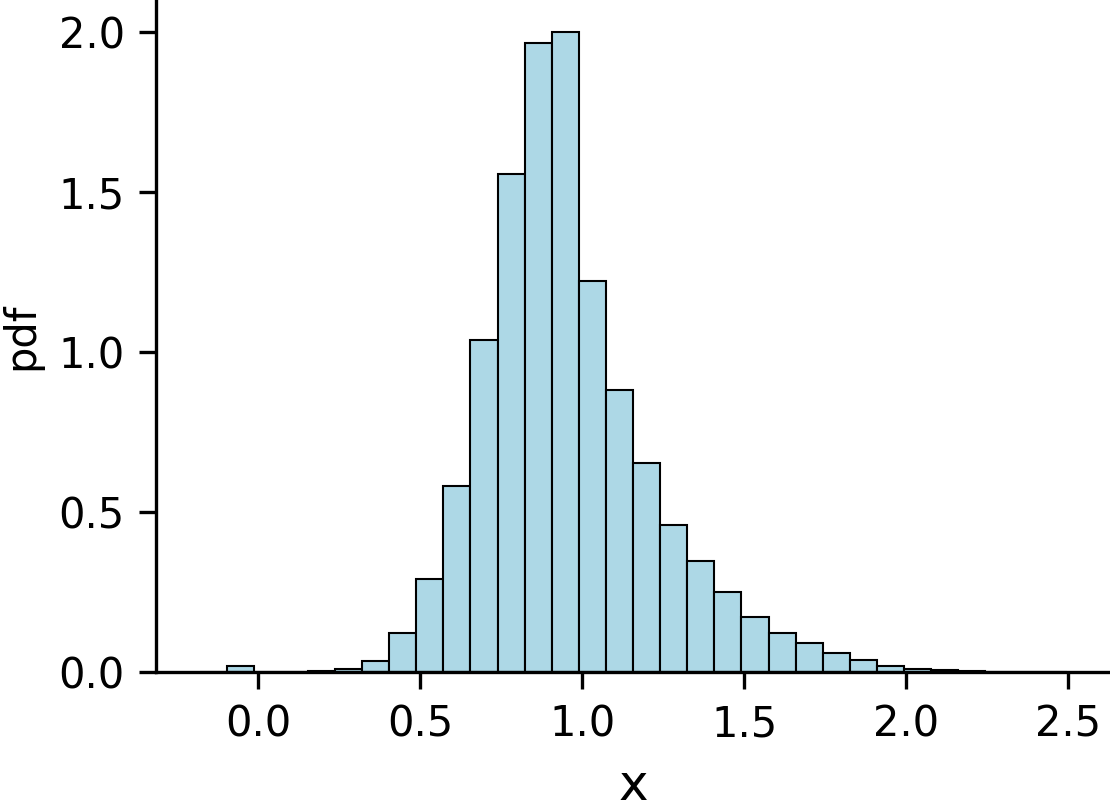

In [35]:
fname = 'eigenvalue_dist_mean'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [36]:
# parameters
# nbins='doane'
nbins = 2**5

figsize=(8,3)
dpi=300
lw=0.5
elw=0.5
ms=4
window=7
xmax = None # in mean value unit
ymin =1.0e-3 # for log scale only

nt = len(Es)

norm = mco.Normalize(vmin=0, vmax=nt-1)
cmap = cm.rainbow
colors = cmap(norm(np.arange(nt)))

XYs=[]
indices = np.arange(1, int(nt/window))
for t in indices:
# # unfolded gaps
    hist, edges = np.histogram(Es[(t-1)*window:t*window], bins=nbins, density=True)
    nbins = len(edges) - 1

    X = 0.5*(edges[:-1]+edges[1:])
    XYs.append([X,hist])

# compute the total mean
xmean = np.mean(Es.to_numpy().astype('float64'))

# make figure
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = mgs.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for k in range(len(indices)):
    X,Y = XYs[k]
    X /= xmean
    Y *= xmean
    a = (indices[k]-1)*window
    color=colors[(indices[k]-1)*window]
    ax1.plot(X, Y, 'o', lw=lw, color=color, mfc='none', mew=lw, ms=ms)
    ax2.plot(X, Y, 'o', lw=lw, color=color, mfc='none', ms=ms)

for ax in ax1,ax2:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
    ax.tick_params(axis='both', length=4)
    ax.set_xlabel("x", fontsize='large')
    ax.set_ylabel("pdf", fontsize='medium')
    ax.set_xlim(0., xmax)
ax1.set_ylim(0,None)
ax2.set_yscale('log')
ax2.set_ylim(ymin,None)

gs.tight_layout(fig, rect=[0.,0.,0.95,1.])
# plt.show()

cax = fig.add_axes(rect=[0.99,0.2,0.01,0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, extendfrac='auto')
# ticks = cbar.get_ticks()
nmonth = (times[-1].year-times[0].year)*12 + (times[-1].month-times[0].month)
tick_values = np.array([times[0] + relativedelta(months=i) for i in range(nmonth+1)])
tick_values = tick_values[::2]
ticks = [times.index(t) for t in tick_values]
# labels = [times[(t-1)*window].strftime('%Y-%m-%d') for t in np.array(ticks, dtype=np.int_)]
labels = [t.strftime('%Y-%m-%d') for t in tick_values]
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

fname = 'eigenvalue_dist'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_dist.png
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_dist.svg


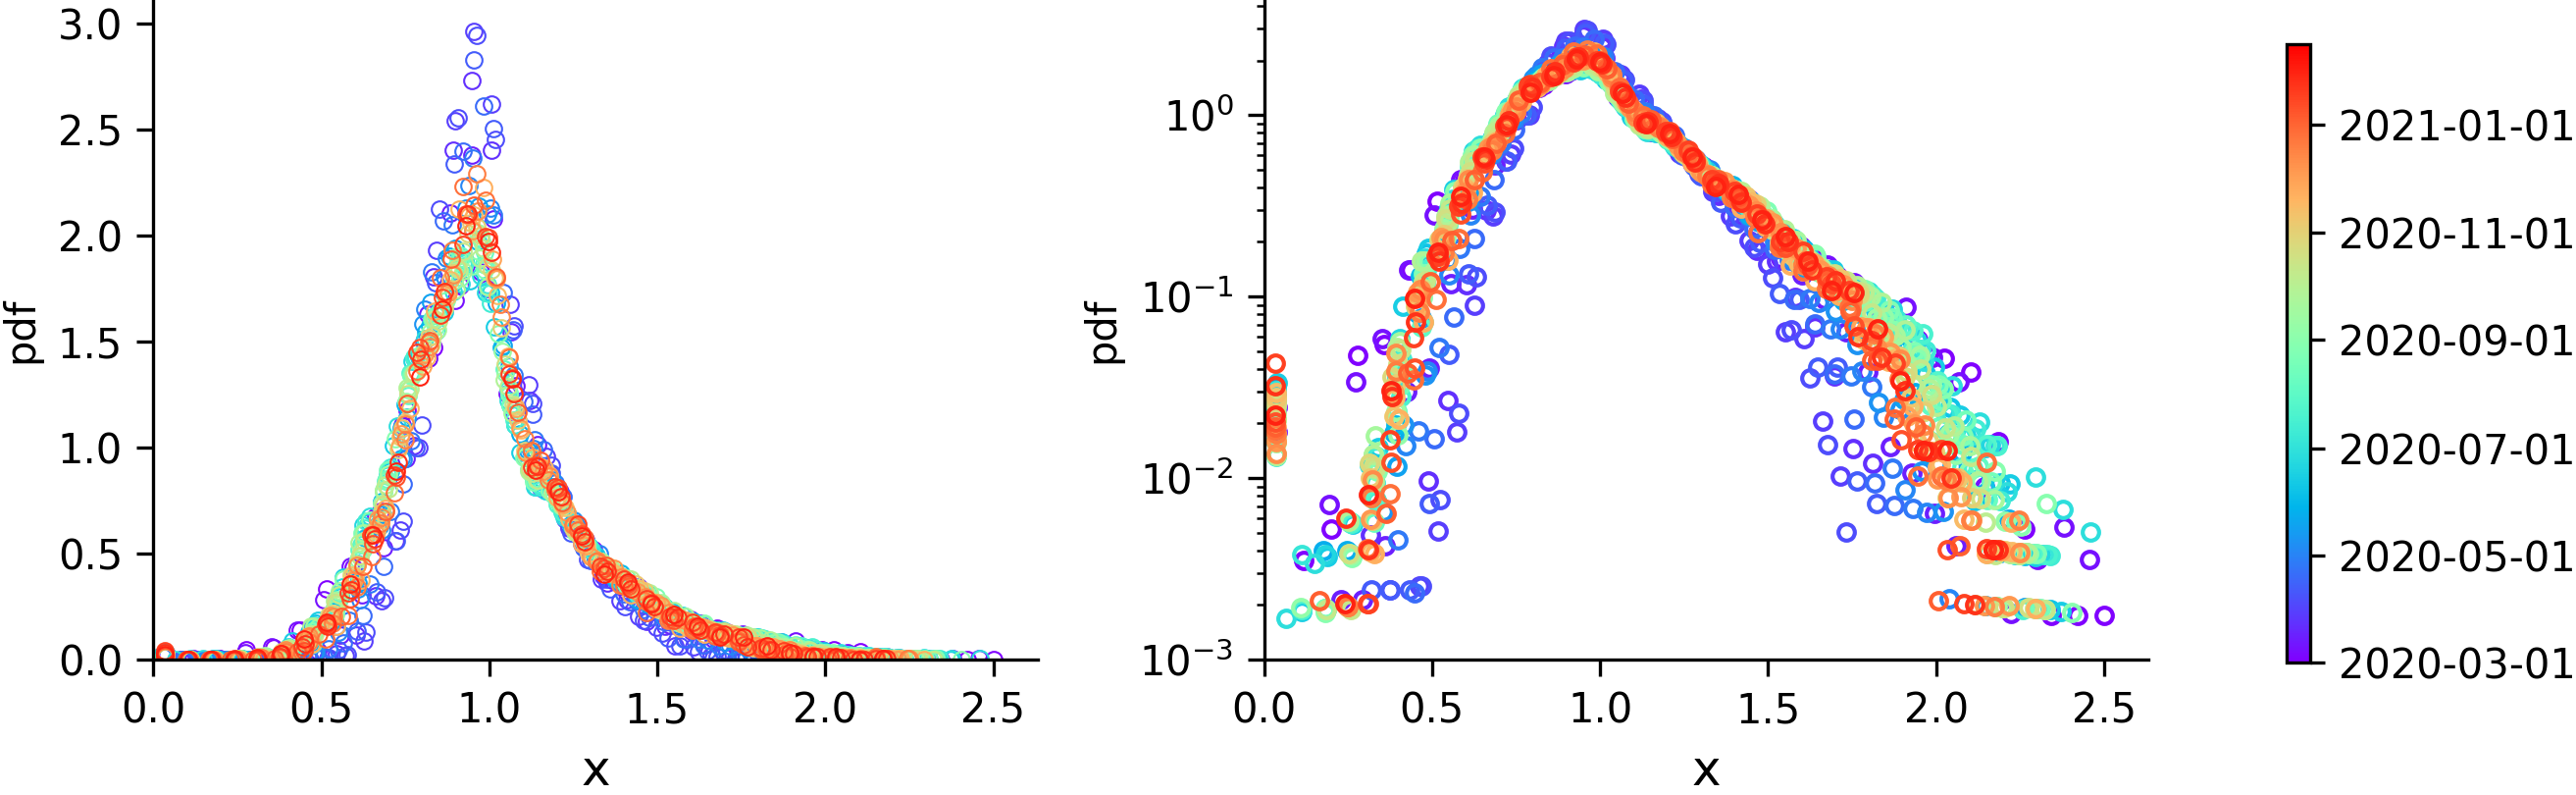

In [37]:
fname = 'eigenvalue_dist'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=8./3*360)

In [38]:
# parameters
ninterp = 2**5
nbins = 2**8
deg=12
aper = 1.

figsize=(8,3)
dpi=300
lw=0.5
elw=0.5
ms=4
window=7
xmax = 5 # in mean value unit
ymin =1.0e-4 # for log scale only

E0 = np.min(Es.to_numpy().astype('float64'))
Es_cent = Es.to_numpy().astype('float64') - E0

# unfolded gaps
hist, edges = unfold_positive(Es_cent, n=ninterp, deg=deg, nbins=nbins, aper=aper)
nbins = len(edges) - 1

# remove values smaller than 0
# problem in polynomial fitting
imax = np.argwhere(edges < 0.).ravel()[-1] + 1 
edges = edges[imax:]
hist = hist[imax:]
dx = np.diff(edges)[0]
Z = np.sum(hist)*dx
hist /= Z
X = 0.5*(edges[:-1]+edges[1:])

# compute the total mean
xmean = np.sum(X*hist*dx)
xvar = np.sum(X**2*hist*dx)
xvar -= xmean**2
dx /= xmean
X /= xmean
edges /= xmean
hist *= xmean

# make figure
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = mgs.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.bar(edges[:-1], hist, dx, lw=0, color='lightblue', ec='k')
ax2.bar(edges[:-1], hist, dx, lw=0, color='lightblue', ec='k')

X=np.linspace(0.,xmax,100)
Y=np.exp(-X)
ax1.plot(X,Y,'k-',lw=0.5)
ax2.plot(X,Y,'k-',lw=0.5)

Y = np.pi*0.5*X*np.exp(-np.pi*X**2/4.)
ax1.plot(X,Y,'k-',lw=0.5)
ax2.plot(X,Y,'k-',lw=0.5)

# ax.legend(loc='best', fontsize='medium', frameon=False)
for ax in ax1,ax2:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
    ax.tick_params(axis='both', length=4)
    ax.set_xlabel("x", fontsize='large')
    ax.set_ylabel("pdf", fontsize='medium')
    ax.set_xlim(0., xmax)
ax1.set_ylim(0,None)
ax2.set_yscale('log')
ax2.set_ylim(ymin,None)

gs.tight_layout(fig, rect=[0.,0.,0.95,1.])
# plt.show()

fname = 'eigenvalue_gaps_unfolded_mean'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_gaps_unfolded_mean.png
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_gaps_unfolded_mean.svg


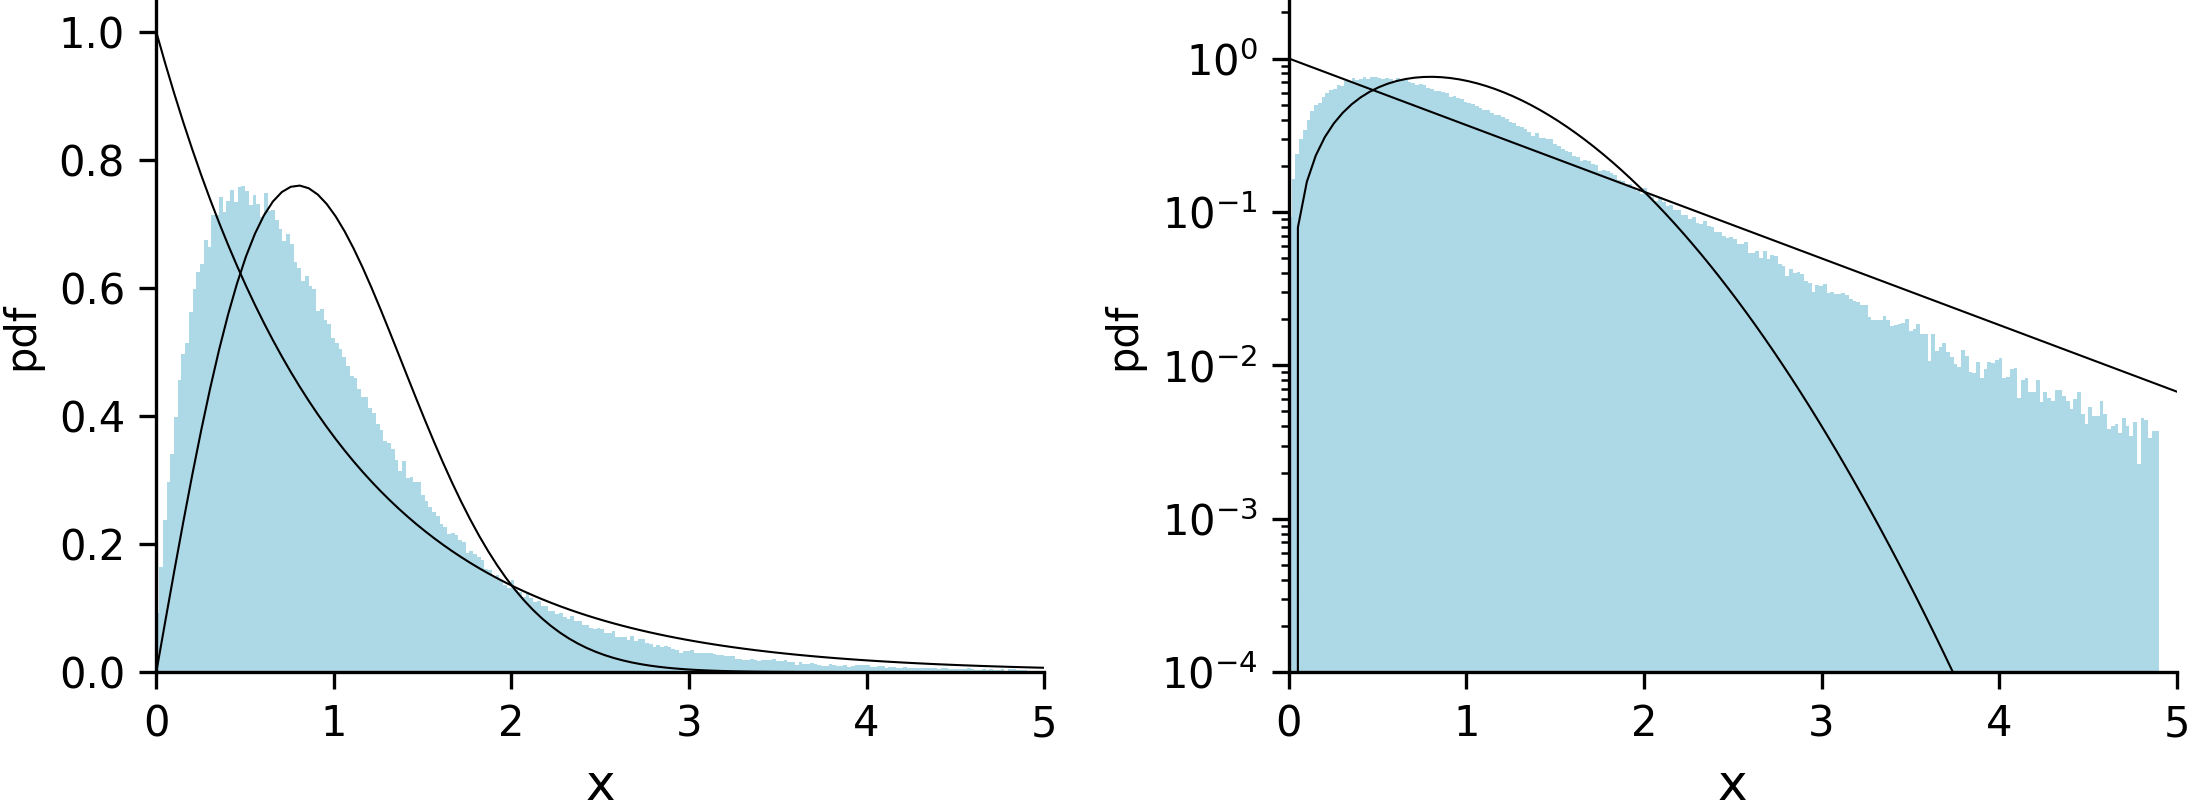

In [39]:
fname = 'eigenvalue_gaps_unfolded_mean'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=8./3*360)

In [40]:
# compute the entropy of the level spacing distribution

# parameters
ninterp = 2**5
deg=12
Es_cent_unif = np.concatenate([np.zeros((1, N-1)), [[N]]], axis=1)
unif = False

if unif:
    Es_mean = np.copy(Es_cent_unif)
    aper = 0.
else:
    Es_mean = np.copy(Es_cent)
    aper = 1.

for i in range(4,11):
    nbins = 2**i
    # unfolded gaps
    hist, edges = unfold_positive(Es_mean, n=ninterp, deg=deg, nbins=nbins, aper=aper)
#     hist, edges = np.histogram(Es_mean, bins=nbins, density=True)
    dx = np.diff(edges)[0]
    nbins = len(edges) - 1

    # remove values smaller than 0
    # problem in polynomial fitting
    ilist = np.argwhere(edges < 0.).ravel()
    if len(ilist) > 0.:
        imax = ilist[-1] + 1 
        edges = edges[imax:]
        hist = hist[imax:]
        dx = np.diff(edges)[0]
        Z = np.sum(hist)*dx
        hist /= Z
    X = 0.5*(edges[:-1]+edges[1:])

    # compute the total mean
    xmean = np.sum(X*hist*dx)
    xvar = np.sum(X**2*hist*dx)
    xvar -= xmean**2
    dx /= xmean
    X /= xmean
    edges /= xmean
    hist *= xmean

    entr1 = -dx*np.sum(xlogy(hist,hist*dx))
    entr2 = -dx*np.sum(xlogy(hist,hist))
    print(nbins, entr1, entr2)

16 1.9187966273337367 0.76864642831419
32 2.6788947321577647 0.895942582638885
64 3.3685291994611175 0.8925879995626188
128 4.060612631519883 0.8915848446444903
256 4.758209207015414 0.8979743275451991
512 5.4508887484070545 0.8975092353745759
1024 6.143402248708681 0.8968749035580929


In [41]:
# parameters
ninterp = 2**5
nbins = 2**5
deg=12

figsize=(8,3)
dpi=300
lw=0.5
elw=0.5
ms=4
window=7
xmax = 5 # in mean value unit
ymin =1.0e-4 # for log scale only

E0 = np.min(Es.to_numpy().astype('float64'))
Es_cent = Es - E0

nt = len(Es)

norm = mco.Normalize(vmin=0, vmax=nt-1)
cmap = cm.rainbow
colors = cmap(norm(np.arange(nt)))

XYs=[]
indices = np.arange(1, int(nt/window))
for t in indices:
# # unfolded gaps
    hist, edges = unfold_positive(Es_cent[(t-1)*window:t*window], n=ninterp, deg=deg, nbins=nbins)
    nbins = len(edges) - 1

    X = 0.5*(edges[:-1]+edges[1:])

    # remove values smaller than 0
    # problem in polynomial fitting
    idx = ~(X < 0.)
    hist = hist[idx]
    X = X[idx]
    dx = np.diff(X)[0]
    Z = np.sum(hist)*dx
    hist /= Z
    
    XYs.append([X,hist])

# compute the total mean
hist, edges = unfold_positive(Es_cent[(t-1)*window:t*window], n=ninterp, deg=deg, nbins=nbins)
nbins = len(edges) - 1

X = 0.5*(edges[:-1]+edges[1:])

# remove values smaller than 0
# problem in polynomial fitting
idx = ~(X < 0.)
hist = hist[idx]
X = X[idx]
dx = np.diff(X)[0]
Z = np.sum(hist)*dx
hist /= Z

xmean = np.sum(X*hist*np.diff(X)[0])
xvar = np.sum(X**2*hist*np.diff(X)[0])
xvar -= xmean**2

# make figure
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = mgs.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for k in range(len(indices)):
    X,Y = XYs[k]
    X /= xmean
    Y *= xmean
    a = (indices[k]-1)*window
    color=colors[(indices[k]-1)*window]
    ax1.plot(X, Y, 'o', lw=lw, color=color, mfc='none', mew=lw, ms=ms)
    ax2.plot(X, Y, 'o', lw=lw, color=color, mfc='none', ms=ms)
# ax.errorbar(X[idx], hist[idx], yerr=w_err[idx], ls='-', marker='o', lw=lw, elinewidth=elw, ms=ms, color='darkblue')

X=np.linspace(0.,xmax,100)
Y=np.exp(-X)
ax1.plot(X,Y,'k-',lw=0.5)
ax2.plot(X,Y,'k-',lw=0.5)

Y = np.pi*0.5*X*np.exp(-np.pi*X**2/4.)
ax1.plot(X,Y,'k-',lw=0.5)
ax2.plot(X,Y,'k-',lw=0.5)

# ax.legend(loc='best', fontsize='medium', frameon=False)
for ax in ax1,ax2:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
    ax.tick_params(axis='both', length=4)
    ax.set_xlabel("x", fontsize='large')
    ax.set_ylabel("pdf", fontsize='medium')
    ax.set_xlim(0., xmax)
ax1.set_ylim(0,None)
ax2.set_yscale('log')
ax2.set_ylim(ymin,None)

gs.tight_layout(fig, rect=[0.,0.,0.95,1.])
# plt.show()

cax = fig.add_axes(rect=[0.99,0.2,0.01,0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, extendfrac='auto')
# ticks = cbar.get_ticks()
nmonth = (times[-1].year-times[0].year)*12 + (times[-1].month-times[0].month)
tick_values = np.array([times[0] + relativedelta(months=i) for i in range(nmonth+1)])
tick_values = tick_values[::2]
ticks = [times.index(t) for t in tick_values]
# labels = [times[(t-1)*window].strftime('%Y-%m-%d') for t in np.array(ticks, dtype=np.int_)]
labels = [t.strftime('%Y-%m-%d') for t in tick_values]
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

fname = 'eigenvalue_gaps_unfolded'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_gaps_unfolded.png
Written file: ../figures/12-infectivity_matrix_properties/eigenvalue_gaps_unfolded.svg


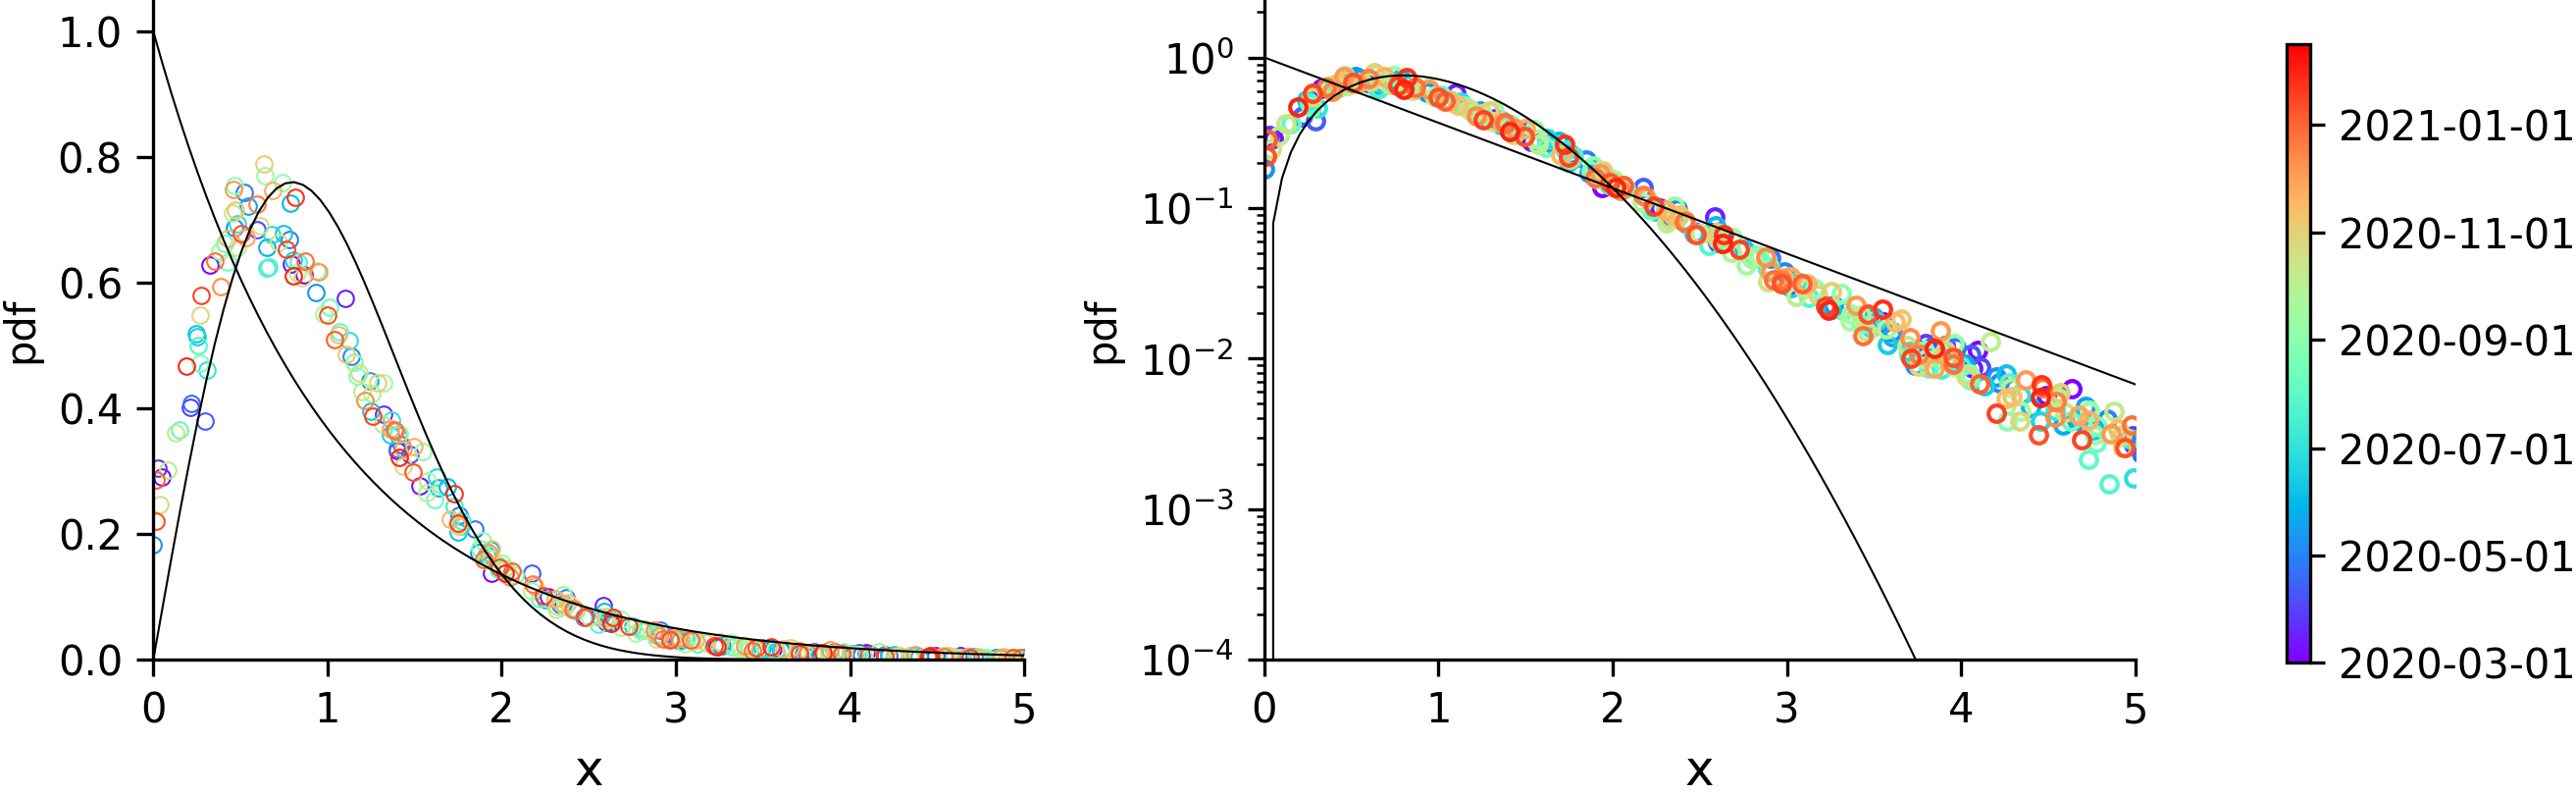

In [42]:
fname = 'eigenvalue_gaps_unfolded'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=8./3*360)